<a href="https://colab.research.google.com/github/ardalanebrahimi/EDU/blob/master/Visualizing-convnets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from keras  import models
from google.colab import drive
import keras.backend as K

Using TensorFlow backend.


In [0]:
drive.mount('/content/drive')
#drive.mount("/content/drive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from keras.models import load_model
#model = load_model('cifar10_small.h5')
model = load_model('/content/drive/My Drive/cifar10/cifar10_small_5_Aug_shape150_500epc.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 37, 37, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 18, 18, 128)       73856     
__________

<function matplotlib.pyplot.show>

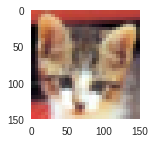

In [0]:
base_dir = '/content/cifar10'
img_path = os.path.join(base_dir,'train/10557_cat.png')
img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /=255.

plt.imshow(img_tensor[0])
plt.grid(None)
plt.rcParams["figure.figsize"] = (20,20)
plt.show

In [0]:
layer_outputs = [layer.output for layer in model.layers[:12]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 150, 150, 32)


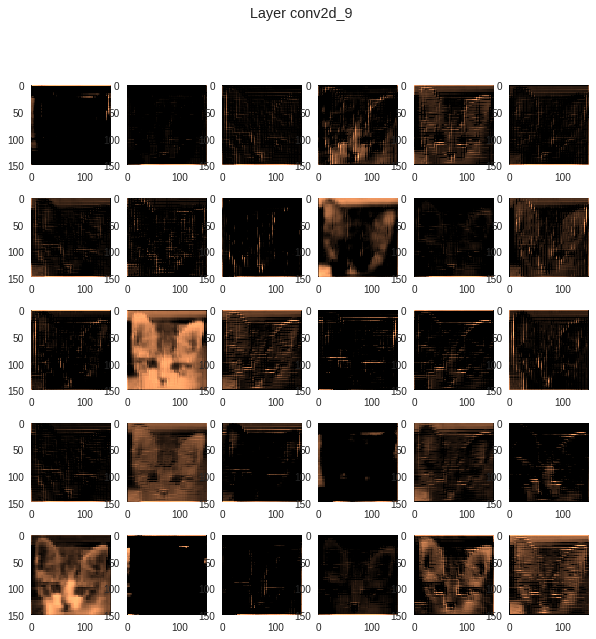

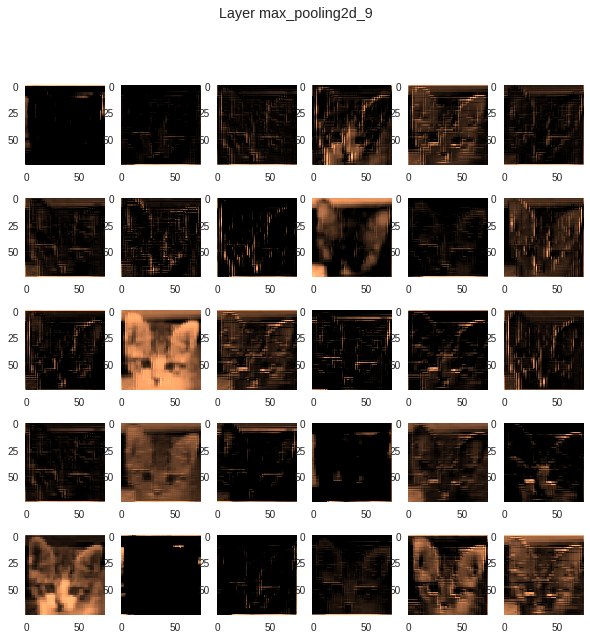

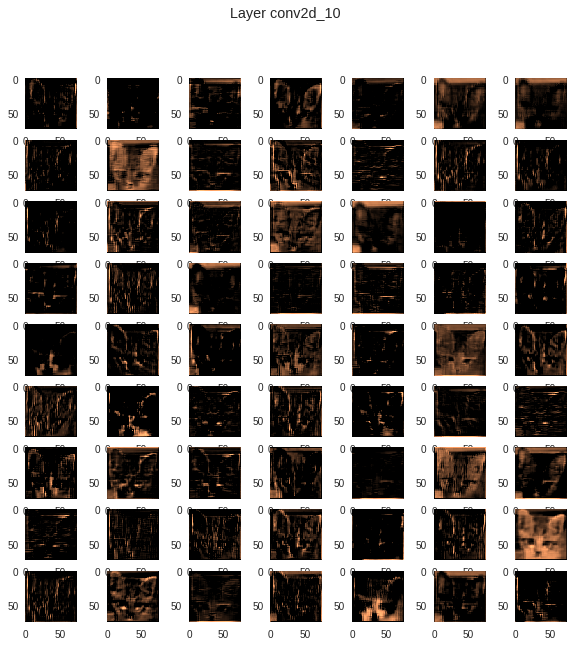

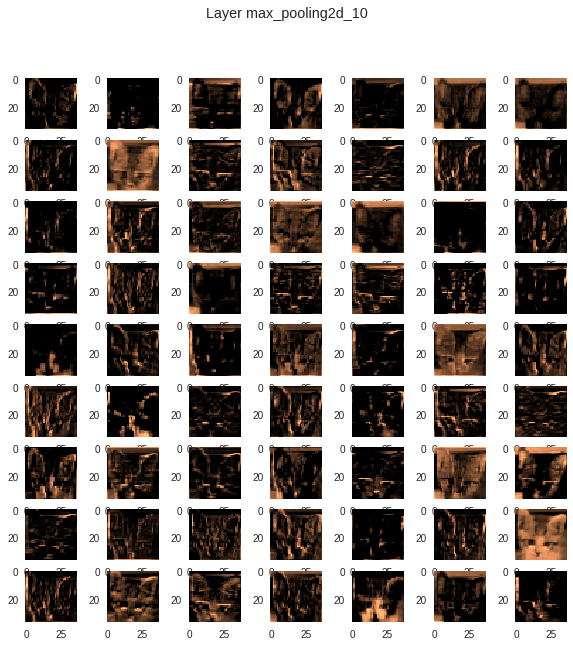

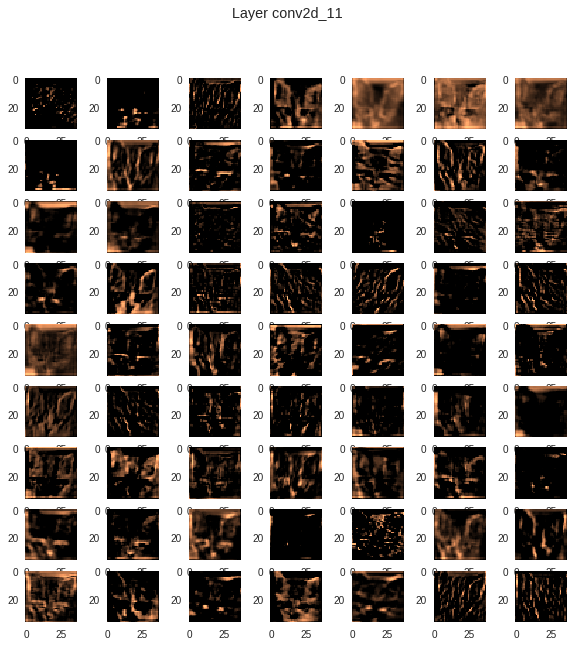

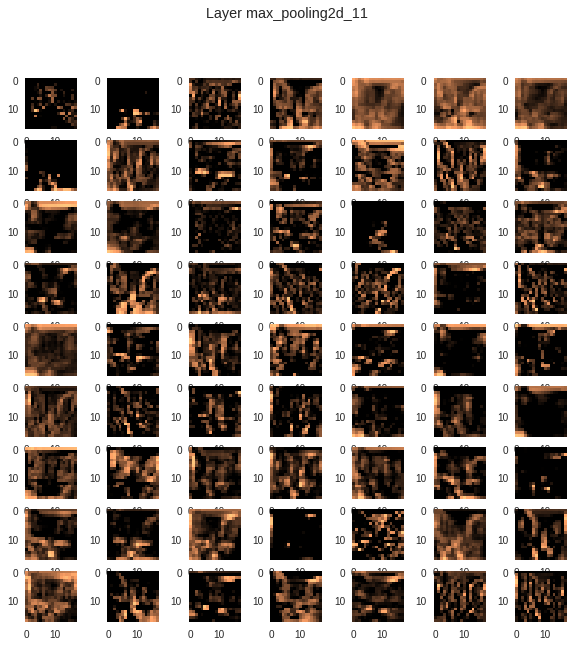

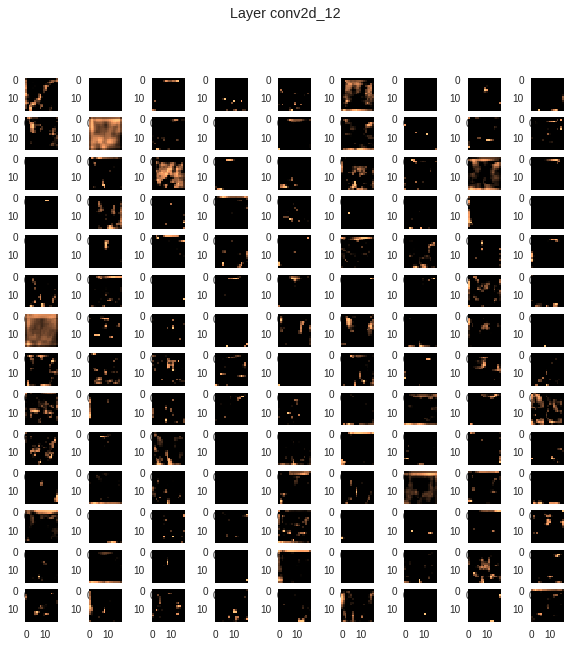

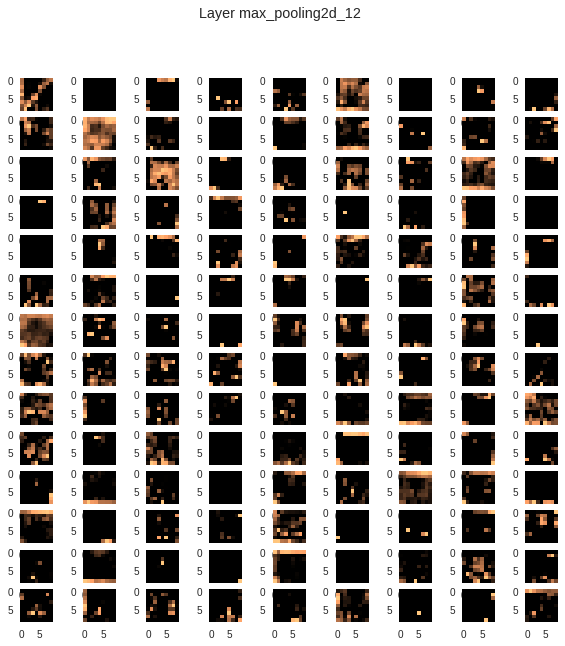

In [0]:
def show_layers(layer,LayerName,col_size,row_size):
  filter_index = 0
  fig, ax = plt.subplots(row_size, col_size, figsize=(10,10))
  fig.suptitle('Layer '+LayerName) 
  for row in range(0,row_size): 
    for col in range(0,col_size):
      ax[row][col].grid(None)
      ax[row][col].imshow(activations[layer][0,:,:,filter_index],cmap="copper")
      filter_index += 1
      
show_layers(0,'conv2d_9',6,5)
show_layers(1,'max_pooling2d_9',6,5)
show_layers(2,'conv2d_10 ',7,9)
show_layers(3,'max_pooling2d_10',7,9)
show_layers(4,'conv2d_11',7,9)
show_layers(5,'max_pooling2d_11',7,9)
show_layers(6,'conv2d_12',9,14)
show_layers(7,'max_pooling2d_12',9,14)

In [0]:
from keras.applications import VGG16
from keras import backend as K
model = VGG16(weights='imagenet',include_top=False)

layer_name='block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

grads = K.gradients(loss, model.input)[0]
grads /= (K.sqrt(K.mean(K.sqrt(grads))) + 1e-5)

iterate = K.function([model.input], [loss,grads])

input_img_data = np.random.random((1, 32, 32, 3)) *20 +128

step = 1.
for i in range(40):
  loss_value, grads_value = iterate([input_img_data])
  input_img_data += grads_value * step

58892288/58889256 [==============================] - 2s 0us/step


In [52]:
from __future__ import print_function

import numpy as np
import time
from keras.preprocessing.image import save_img
from keras.applications import vgg16
from keras import backend as K

# dimensions of the generated pictures for each filter.
img_width = 128
img_height = 128

def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


# build the VGG16 network with ImageNet weights
#model = vgg16.VGG16(weights='imagenet', include_top=False)
model = load_model('/content/drive/My Drive/cifar10/cifar10_small_5_Aug_shape150_500epc.h5')
print('Model loaded.')

model.summary()

# this is the placeholder for the input images
input_img = model.input

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])


def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())

def create_filter_vis(_layername, _filter_index_range = 64, _dim = 5):
  kept_filters = []
  for filter_index in range(_filter_index_range):
      # we only scan through the first 200 filters,
      # but there are actually 512 of them
      #print('Processing filter %d' % filter_index)
      start_time = time.time()

      # we build a loss function that maximizes the activation
      # of the nth filter of the layer considered
      layer_output = layer_dict[_layername].output
      if K.image_data_format() == 'channels_first':
          loss = K.mean(layer_output[:, filter_index, :, :])
      else:
          loss = K.mean(layer_output[:, :, :, filter_index])

      # we compute the gradient of the input picture wrt this loss
      grads = K.gradients(loss, input_img)[0]

      # normalization trick: we normalize the gradient
      grads = normalize(grads)

      # this function returns the loss and grads given the input picture
      iterate = K.function([input_img], [loss, grads])

      # step size for gradient ascent
      step = 1.

      # we start from a gray image with some random noise
      if K.image_data_format() == 'channels_first':
          input_img_data = np.random.random((1, 3, img_width, img_height))
      else:
          input_img_data = np.random.random((1, img_width, img_height, 3))
      input_img_data = (input_img_data - 0.5) * 20 + 128

      # we run gradient ascent for 20 steps
      for i in range(20):
          loss_value, grads_value = iterate([input_img_data])
          input_img_data += grads_value * step

          #print('Current loss value:', loss_value)
          if loss_value <= 0.:
              # some filters get stuck to 0, we can skip them
              break

      # decode the resulting input image
      if loss_value > 0:
          img = deprocess_image(input_img_data[0])
          kept_filters.append((img, loss_value))
      end_time = time.time()
      #print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

  # we will stich the best 64 filters on a 8 x 8 grid.
  n = _dim

  # the filters that have the highest loss are assumed to be better-looking.
  # we will only keep the top 64 filters.
  kept_filters.sort(key=lambda x: x[1], reverse=True)
  kept_filters = kept_filters[:n * n]

  # build a black picture with enough space for
  # our 8 x 8 filters of size 128 x 128, with a 5px margin in between
  margin = 5
  width = n * img_width + (n - 1) * margin
  height = n * img_height + (n - 1) * margin
  stitched_filters = np.zeros((width, height, 3))

  # fill the picture with our saved filters
  for i in range(n):
      for j in range(n):
          img, loss = kept_filters[i * n + j]
          width_margin = (img_width + margin) * i
          height_margin = (img_height + margin) * j
          stitched_filters[
              width_margin: width_margin + img_width,
              height_margin: height_margin + img_height, :] = img

  # save the result to disk
  save_img(_layername+'_stitched_filters_%dx%d.png' % (n, n), stitched_filters)


Model loaded.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 37, 37, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 18, 18, 128)       73856  

In [0]:
create_filter_vis('conv2d_10',_filter_index_range = 64, _dim = 7)

In [0]:
create_filter_vis('conv2d_11',_filter_index_range = 64, _dim = 7)

In [48]:
kept_filters.size()

AttributeError: ignored

In [0]:
create_filter_vis('conv2d_12',_filter_index_range = 128, _dim = 7)

In [56]:
n=7
# fill the picture with our saved filters
for i in range(n):
  for j in range(n):
    img, loss = kept_filters[i * n + j]
    width_margin = (img_width + margin) * i
    height_margin = (img_height + margin) * j
    stitched_filters[
        width_margin: width_margin + img_width,
        height_margin: height_margin + img_height, :] = img
# save the result to disk
save_img(_layername+'_stitched_filters_%dx%d.png' % (n, n), stitched_filters)

ValueError: ignored

In [0]:
from keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')

553467904/553467096 [==============================] - 34s 0us/step


In [73]:
model = load_model('/content/drive/My Drive/cifar10/cifar10_small_5_Aug_shape150_500epc.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 37, 37, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 18, 18, 128)       73856     
__________

In [0]:
from keras.preprocessing import image
#from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img_path = '/content/drive/My Drive/cifar/sample_dog2.jpg'
img = image.load_img(img_path, target_size=(150,150))

x= image.img_to_array(img)
x=np.expand_dims(x, axis=0)
x=preprocess_input(x)

In [90]:
preds = model.predict(x)
#print('Predict:', decode_predictions(preds,top=3)[0])
np.argmax(preds[0])

6

In [92]:
dog_output = model.output[:,6]
last_conv_layer = model.get_layer('conv2d_12')
grads = K.gradients(dog_output,last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0,1,2))
iterate=K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(127):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
 
heatmap = np.mean(conv_layer_output_value, axis = -1)
heatmap = np.maximum(heatmap, 0)
heatmap /=np.max(heatmap)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<function matplotlib.pyplot.show>

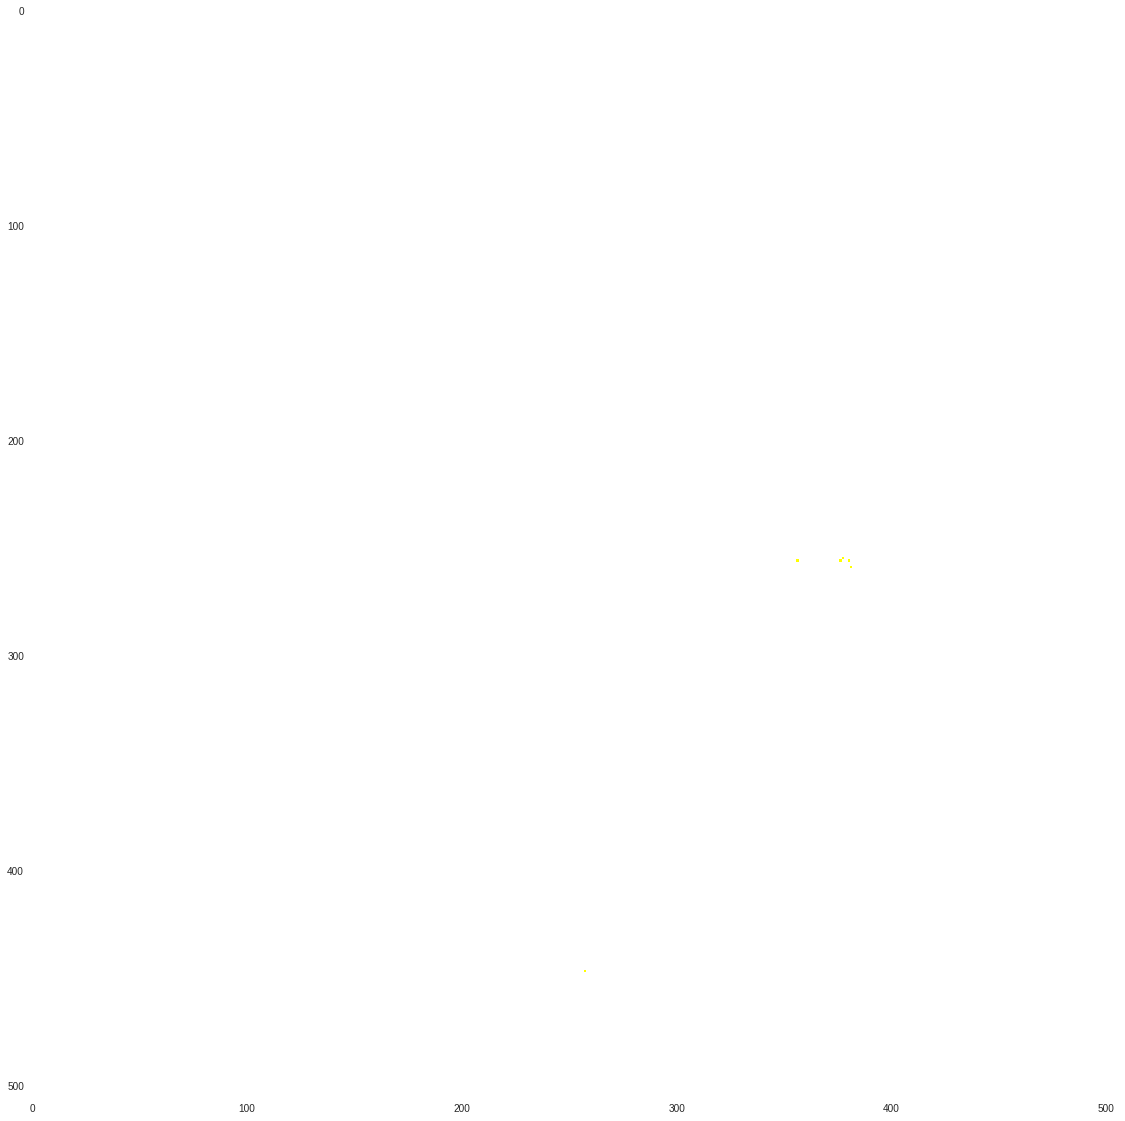

In [93]:
import cv2
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = heatmap * 0.4 + img

cv2.imwrite('/content/drive/My Drive/cifar/sample_dog21_r_heatmap.jpg', superimposed_img)
plt.imshow(superimposed_img)
plt.show